In [238]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

import os
import shutil
os.makedirs("/kaggle/working/window-generator", exist_ok=True)
shutil.copy("/kaggle/input/window-generator/window_generator.py", "/kaggle/working/window-generator/window_generator.py")

import kagglehub
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

In [12]:
import sys
sys.path.append('/kaggle/working/window-generator')
from window_generator import WindowGenerator

In [13]:
america_electric_power = pd.read_csv("/kaggle/input/hourly-energy-consumption/AEP_hourly.csv").set_index("Datetime")
america_electric_power.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [14]:
scaler = StandardScaler()
america_electric_power["AEP_MW"] = scaler.fit_transform(america_electric_power[["AEP_MW"]])

In [98]:
length = len(america_electric_power)
train_df = america_electric_power[ : int(length * 0.7)]
val_df = america_electric_power[int(length * 0.7) : int(length * 0.9)]
test_df = america_electric_power[int(length * 0.9) : ]

In [73]:
wg = WindowGenerator(input_width = 24, label_width = 24, shift = 24,
                    train_df = train_df, val_df = val_df, test_df = test_df, label_columns = ["AEP_MW"])
wg

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['AEP_MW']

In [74]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience = 2):
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')
    model.compile(loss = keras.losses.MeanSquaredError(),
                 optimizer = keras.optimizers.Adam(),
                 metrics = [keras.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                       validation_data = window.val,
                       callbacks = [early_stopping])
    return history

# BiLSTM

In [75]:
inputs = Input(shape = (24, 1))

x = layers.Bidirectional(layers.LSTM(32, return_sequences = True))(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences = False))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
  
outputs = layers.Dense(24)(x)

modelLSTM = Model(inputs = inputs, outputs = outputs)

historyLSTM = compile_and_fit(modelLSTM, wg)

Epoch 1/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step - loss: 0.2757 - mean_absolute_error: 0.4004 - val_loss: 0.1746 - val_mean_absolute_error: 0.3190
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.1742 - mean_absolute_error: 0.3207 - val_loss: 0.1534 - val_mean_absolute_error: 0.2928
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.1614 - mean_absolute_error: 0.3083 - val_loss: 0.1460 - val_mean_absolute_error: 0.2882
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.1534 - mean_absolute_error: 0.3006 - val_loss: 0.1298 - val_mean_absolute_error: 0.2667
Epoch 5/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.1462 - mean_absolute_error: 0.2931 - val_loss: 0.1325 - val_mean_absolute_error: 0.2693
Epoch 6/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.1416 - mean_absolute_error: 0.2882 - val_loss: 0.1180 - val_mean_absolute_error: 0.2506
Epoch 7/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - loss: 0.1323 - mea

# CNN - BiLSTM

In [76]:
inputs = Input(shape = (24, 1))

x = layers.Conv1D(64, kernel_size = 1, activation = 'relu', padding = 'same')(inputs)
x = layers.MaxPooling1D(pool_size = 2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.RepeatVector(1)(x)

x = layers.Bidirectional(layers.LSTM(32, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences = False))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(24)(x)

modelCNNLSTM = Model(inputs = inputs, outputs = outputs)

historyCNNLSTM = compile_and_fit(modelCNNLSTM, wg)

Epoch 1/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.5912 - mean_absolute_error: 0.6165 - val_loss: 0.5345 - val_mean_absolute_error: 0.5794
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.5750 - mean_absolute_error: 0.6083 - val_loss: 0.5316 - val_mean_absolute_error: 0.5793
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.5707 - mean_absolute_error: 0.6061 - val_loss: 0.5364 - val_mean_absolute_error: 0.5812
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.5697 - mean_absolute_error: 0.6055 - val_loss: 0.5394 - val_mean_absolute_error: 0.5824


# XGBoost

In [186]:
xgboost_df = america_electric_power.reset_index().copy()
xgboost_df["Datetime"] = pd.to_datetime(xgboost_df["Datetime"])
xgboost_df["hour"] = xgboost_df["Datetime"].dt.hour
xgboost_df["dayofweek"] = xgboost_df["Datetime"].dt.dayofweek
xgboost_df["quarter"] = xgboost_df["Datetime"].dt.quarter
xgboost_df["month"] = xgboost_df["Datetime"].dt.month
xgboost_df["year"] = xgboost_df["Datetime"].dt.year
xgboost_df["dayofyear"] = xgboost_df["Datetime"].dt.dayofyear
xgboost_df["dayofmonth"] = xgboost_df["Datetime"].dt.day
xgboost_df = xgboost_df.set_index("Datetime")

length = len(xgboost_df)
xgboost_train_df = xgboost_df[ : int(length * 0.7)]
xgboost_val_df = xgboost_df[int(length * 0.7) : int(length * 0.9)]
xgboost_test_df = xgboost_df[int(length * 0.9) : ]

In [187]:
def create_features(df, label=None):
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [188]:
X_train, y_train = create_features(xgboost_train_df, label='AEP_MW')
X_val, y_val = create_features(xgboost_val_df, label='AEP_MW')
X_test, y_test = create_features(xgboost_test_df, label='AEP_MW')

In [189]:
xgboost = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror', early_stopping_rounds=10, learning_rate=0.01)
xgboost.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'mae', verbose = False)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Visualization

In [81]:
def plotResults(history, model_name = 'Model'):
    metrics = ['mean_absolute_error', 'loss']
    val_metrics = ['val_mean_absolute_error', 'val_loss']

    epochs = range(1, len(history['loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(25, 5))

    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        ax = axes[i]
        ax.plot(epochs, history[metric], label=f'Train {metric}')
        ax.plot(epochs, history[val_metric], label=f'Val {metric}')
        ax.set_title(metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric)
        ax.legend()

    plt.suptitle(model_name, fontsize = 16)
    plt.tight_layout()
    plt.show()

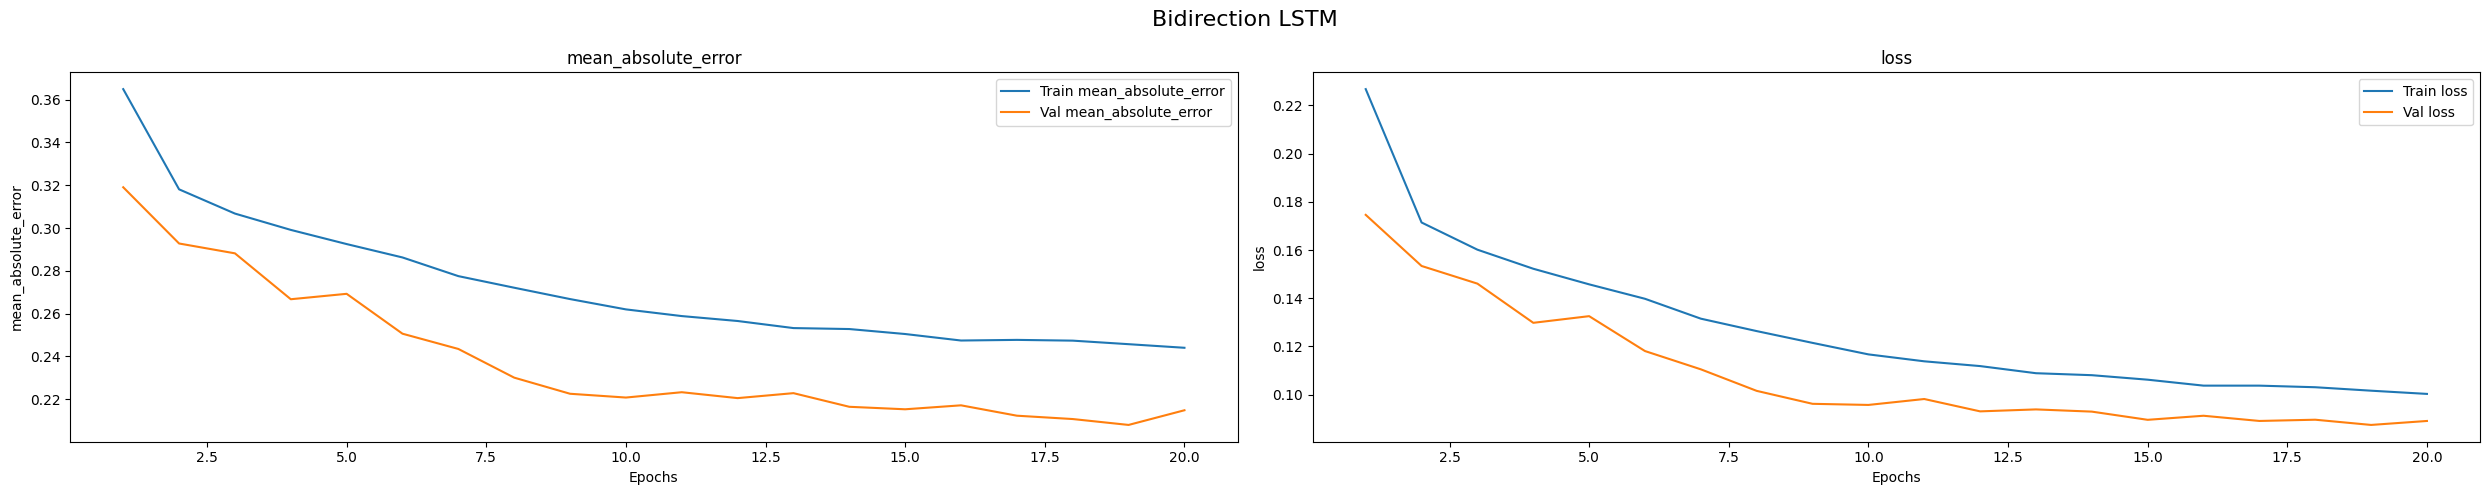

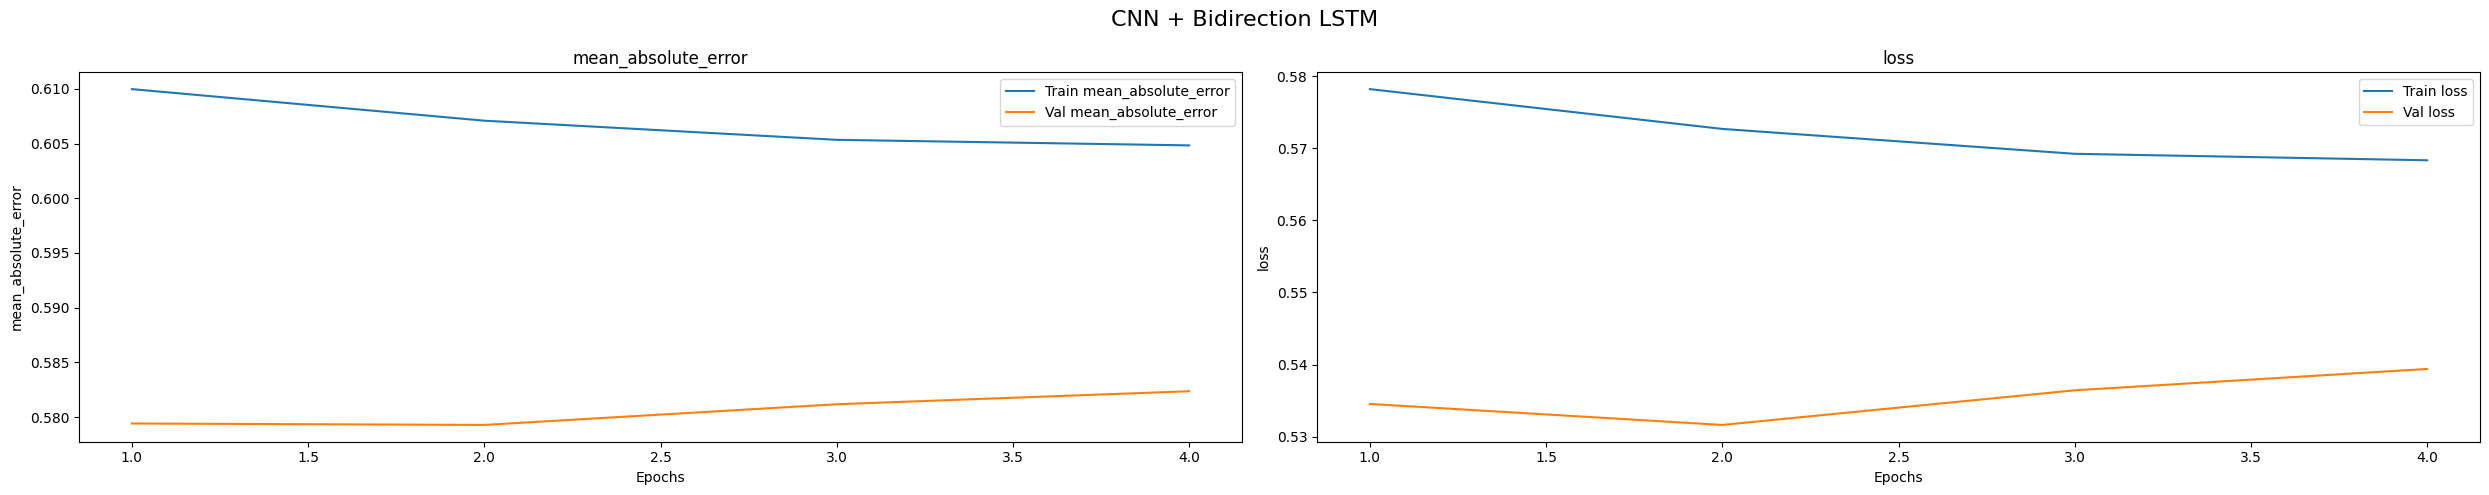

In [82]:
plotResults(historyLSTM.history, model_name = "Bidirection LSTM")
plotResults(historyCNNLSTM.history, model_name = "CNN + Bidirection LSTM")

# Evaluation

In [209]:
def evaluation(model, window, history):
    evaluation = model.evaluate(window.test)
    predictions = model.predict(window.test)
    grouth_true = np.concatenate([y.numpy() for _, y in wg.test], axis = 0).squeeze()
    mae = mean_absolute_error(predictions.flatten(), grouth_true.flatten())
    rmse = mean_squared_error(predictions.flatten(), grouth_true.flatten(), squared = False)
    num_epochs = len(history["loss"])
    return predictions, mae, rmse, num_epochs

In [ ]:
predsLSTM, maeLSTM, rmseLSTM, epochsLSTM = evaluation(modelLSTM, wg, historyLSTM.history)
predsCNNLSTM, maeCNNLSTM, rmseCNNLSTM, epochsCNNLSTM = evaluation(modelCNNLSTM, wg, historyCNNLSTM.history)

print(f"BiLSTM Mean Absolute Error: {maeLSTM}")
print(f"CNN + BiLSTM Mean Absolute Error: {maeCNNLSTM}")
print(f"Number of epochs before early stopping: {epochsLSTM}")
print()
print(f"BiLSTM Root Mean Squared Error: {rmseLSTM}")
print(f"CNN + BiLSTM Root Mean Squared Error: {rmseCNNLSTM}")
print(f"Number of epochs before early stopping: {epochsCNNLSTM}")

BiLSTM Mean Absolute Error: 1.0265687704086304
CNN + BiLSTM Mean Absolute Error: 0.9005711078643799
Number of epochs before early stopping: 20

BiLSTM Root Mean Squared Error: 1.287170171737671
CNN + BiLSTM Root Mean Squared Error: 1.125303864479065
Number of epochs before early stopping: 4


In [ ]:
xgb_preds = xgboost.predict(xgboost_test_df.drop(columns = 'AEP_MW'))
maexgb = mean_absolute_error(xgb_preds, xgboost_test_df["AEP_MW"].values)
rmaexgb = mean_squared_error(xgb_preds, xgboost_test_df["AEP_MW"].values, squared = False)

print(f"XGBoost Mean Absolute Error: {maexgb}")
print(f"XGBoost Root Mean Squared Error: {rmaexgb}")

XGBoost Mean Absolute Error: 0.48695676062075827
XGBoost Root Mean Squared Error: 0.626813112831268


# Forecasting

In [221]:
def forecasting(predictions, window):
    window_idx = 0

    input_range = np.arange(24)
    label_range = np.arange(24, 48)
    
    x, y = next(iter(window.test))
    x_sample = x[window_idx].numpy().squeeze()
    y_sample = y[window_idx].numpy().squeeze()
    y_pred = predictions[window_idx]
    
    plt.figure(figsize = (20, 4))
    plt.plot(input_range, x_sample, label = 'Input', marker = '.')
    plt.plot(label_range, y_sample, label = "Grouth True", marker = 'o')
    plt.plot(label_range, y_pred, label = "Forecast", marker = 'x')
    plt.title("Single Window Forecast")
    plt.xlabel("Time Step")
    plt.legend()
    plt.grid()
    plt.show()

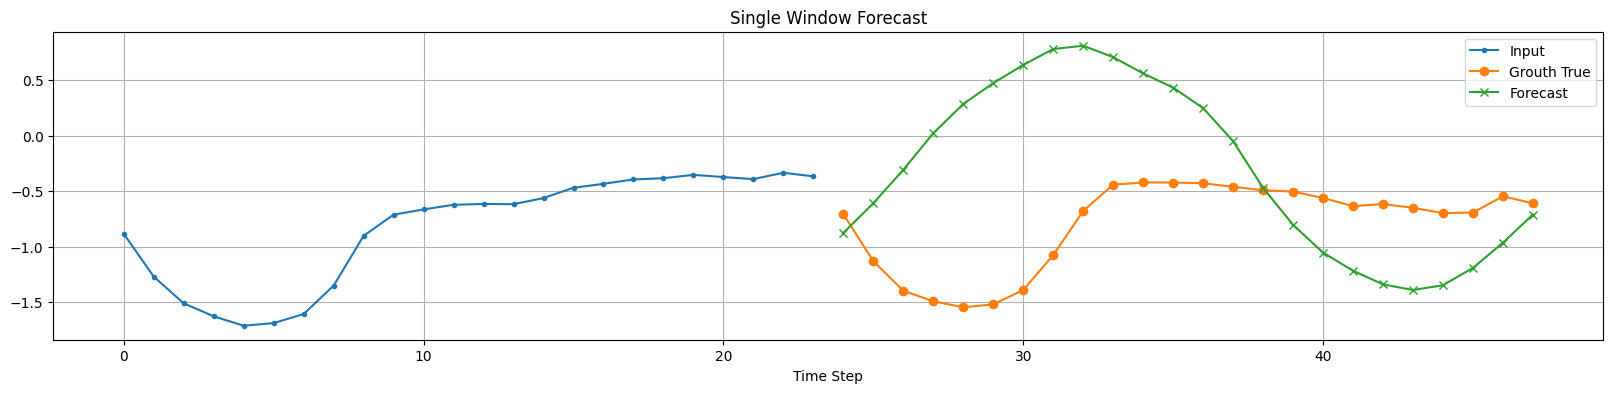

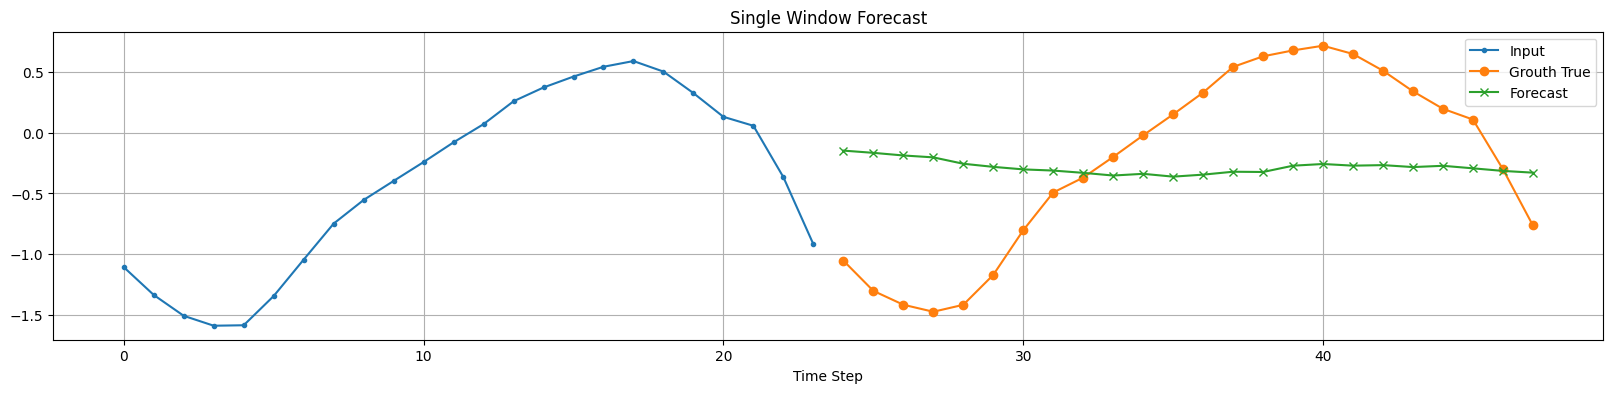

In [223]:
forecasting(predsLSTM, wg)
forecasting(predsCNNLSTM, wg)

In [228]:
def forecast_month_year(attribute, values):
    forecast_df = X_test.copy()
    forecast_df[attribute] = values 
    forecast_df["month_year"] = pd.to_datetime(forecast_df["year"].astype(str) + '-' + forecast_df['month'].astype(str))
    forecast_df = forecast_df.groupby(["month_year"])[attribute].mean().reset_index()
    return forecast_df

In [233]:
gt_ = forecast_month_year("Grouth True", xgboost_test_df["AEP_MW"].values)
xgb_ = forecast_month_year("XGB", xgb_preds)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

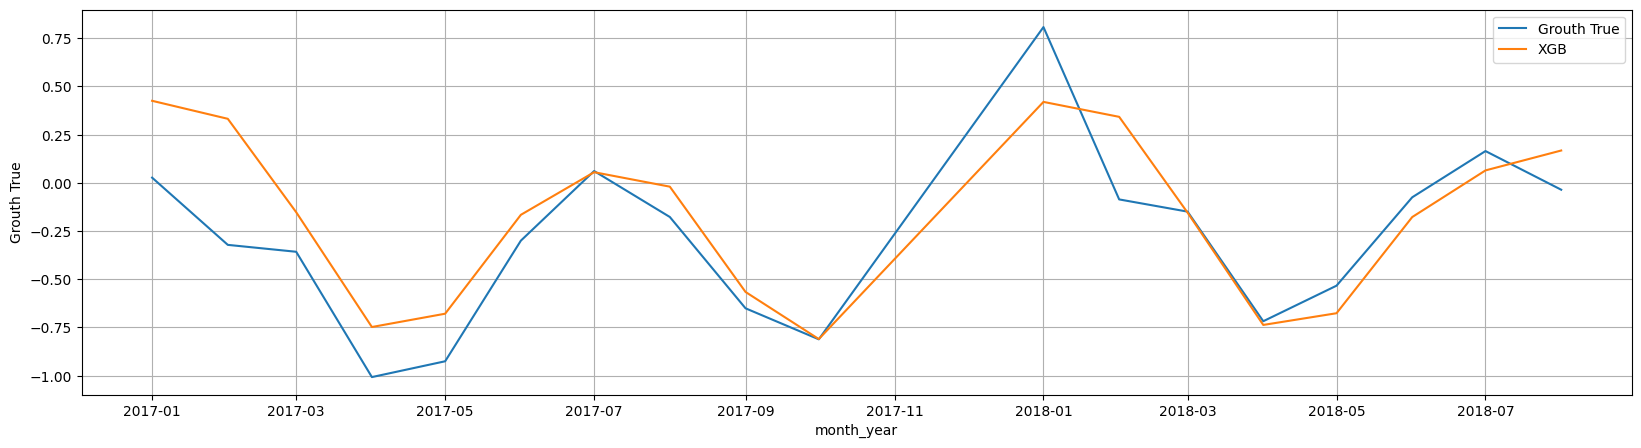

In [240]:
plt.figure(figsize = (20, 5))

sns.lineplot(data = gt_, x = 'month_year', y = 'Grouth True', label = 'Grouth True')
sns.lineplot(data = xgb_, x = 'month_year', y = 'XGB', label = 'XGB')

plt.legend()
plt.grid(True)
plt.show()